# Titanics survivor prediction
> as a part of Titanic: Machine Learning from Disaster competition (https://www.kaggle.com/c/titanic)

![Titanic ship](https://www.englishclub.com/efl/wp-content/uploads/2020/04/titanic.png)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns #visualizing
import matplotlib.pyplot as plt
import joblib

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


# Introduction

"The sinking of the Titanic is one of the most infamous shipwrecks in history.On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. 

Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.<br>While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others." [1]

This notebook will try to find answer to the question that which characteristics of passengers most contribute to their chance of survival ann in the end we'll try to predict wheter given passenger will survive the catastrophe or not?




<a class="anchor" id="0"></a>

## Table of Contents

1. [Data Exploration](#1)
1. [Exploratory Data Analysis](#2)
1. [Data Preprocessing](#3)
1. [Model Selection](#4)
1. [Hyperparameters tuning](#5)
1. [Ensembling (Contruction of voting classifier)](#6)
1. [Prediction and Submission](#7)
1. [Conclusion](#8)


# 1. Data Exploration <a id=1>

## Dataset explanation

Dataset is provided by Kaggle as a part of "Titanic: Machine Learning from Disaster" competition. The goal of this model is to predict whether given passenger will survive the disaster or not based on following features.

1. Survival	: 0 = No, 1 = Yes
1. name     : Passenger name including prefix
1. pclass	: A proxy for socio-economic status (SES) 1 = 1st, 2 = 2nd, 3 = 3rd
1. Sex	    : Male / Female
1. Age	    : Age in years	(Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5)
1. sibsp	: # of siblings / spouses aboard the Titanic	
1. parch	: # of parents / children aboard the Titanic	
1. ticket	: Ticket number	
1. fare	    : Passenger fare	
1. cabin	: Cabin number	
1. embarked	: Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [2]:
#Read data
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')

#Storing Passenger Id for submision
Id = test.PassengerId

In [3]:
#Train set example
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#Test set example
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
print('Train set shape = ' + str(train.shape[0]) +' Rows, ' + str(train.shape[1]) + ' Columns')
print('Test set shape = ' + str(test.shape[0]) +' Rows, ' + str(test.shape[1]) + ' Columns')

#Test set has 1 columns less than Train set (Survived columns (predictions) is unknown)

Train set shape = 891 Rows, 12 Columns
Test set shape = 418 Rows, 11 Columns


In [6]:
#Let's look at brief summary of train set
print(train.info())
print(train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.48659

From above outline : Several attribute need to be checked as they contain some missing value
1. Age
2. Cabin
3. Embarked

In [7]:
train['Ticket'].value_counts()

CA. 2343           7
1601               7
347082             7
347088             6
3101295            6
                  ..
SOTON/OQ 392090    1
31418              1
370369             1
2623               1
392091             1
Name: Ticket, Length: 681, dtype: int64

I decided to drop Cabin feature. Since it contain lots of missing value and there is obscure method to imputes its missing value.

Moreover, ticket attribute seem to have no meaning. It comprised of uninterpretable number and strings, so this will be dropped out too.


# 2.Exploratory Data Analysis <a id=2>

## Univariate analysis

In [8]:
cat_col = ['Pclass','Sex','Embarked']
num_col = ['Age','SibSp','Parch','Fare']


Note that we keep out Name attribute for later since at first glance they might seem to be unique but I think that after preprocessing them we might see some pattern in it

In [9]:
train[num_col].describe()

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


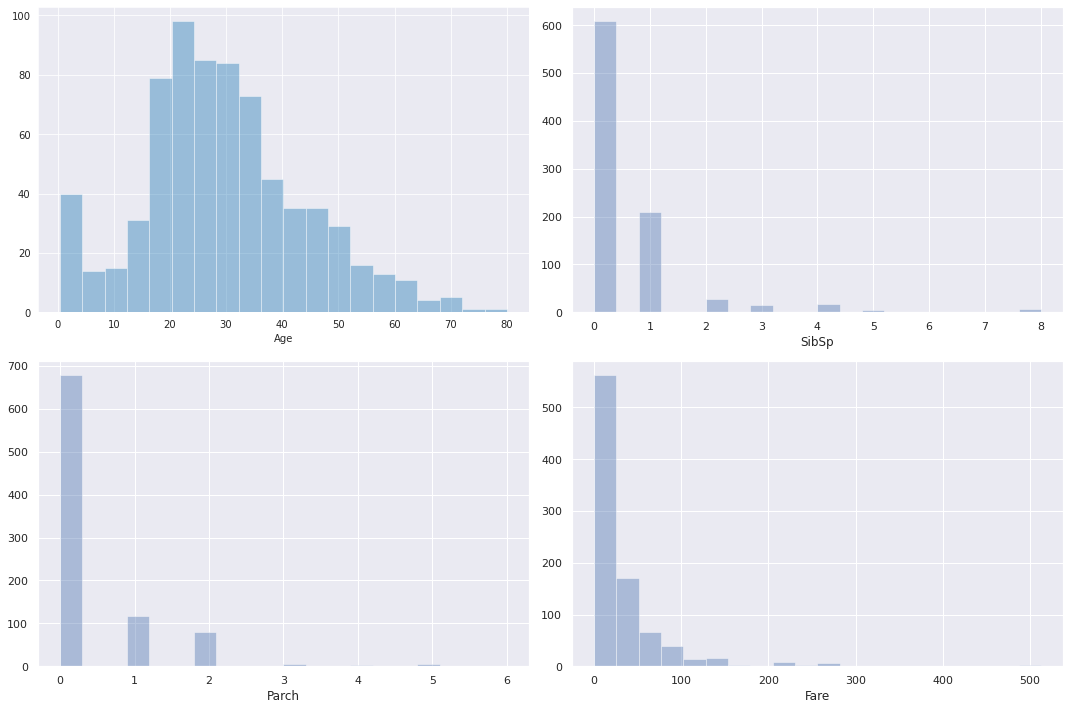

In [10]:
#numerical data
fig = plt.figure(figsize=(15,10))
sns.set_style('darkgrid')
for index,col in enumerate(num_col):
    plt.subplot(2,2,index+1)
    sns.set(font_scale = 1.0)
    sns.distplot(train[col],kde=False, bins = 20)
fig.tight_layout(pad=1.0)

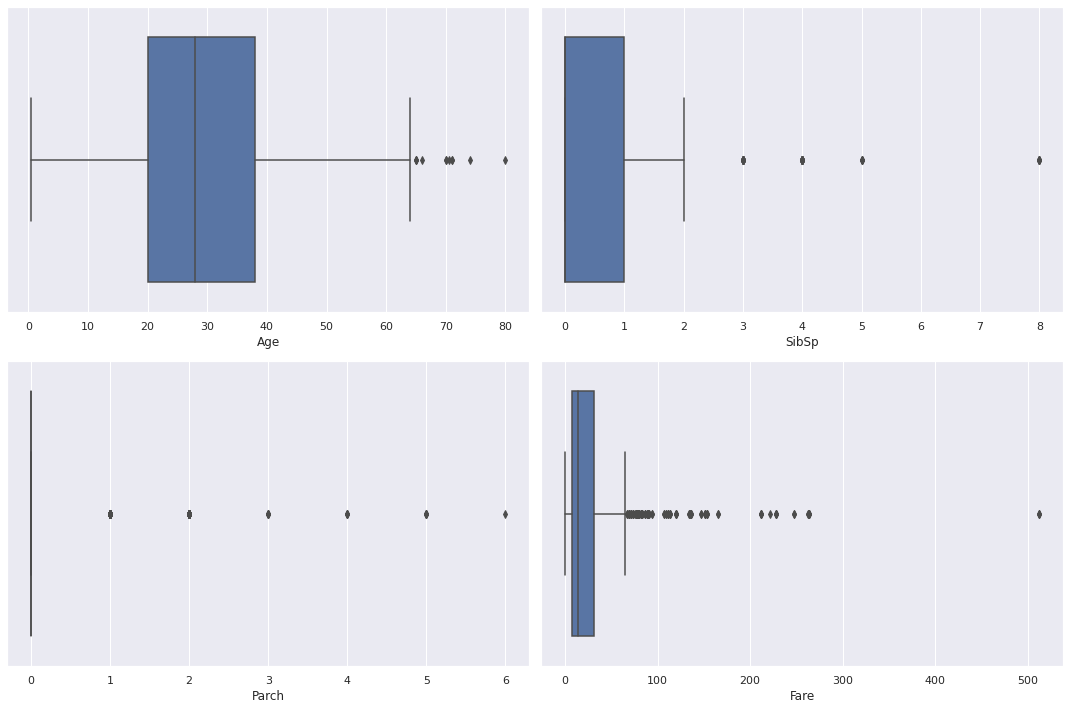

In [11]:
#numerical data
fig = plt.figure(figsize=(15,10))
sns.set_style('darkgrid')
for index,col in enumerate(num_col):
    plt.subplot(2,2,index+1)
    sns.boxplot(train[col])
fig.tight_layout(pad=1.0)

Data observation
* Age : Traveller on board Titanic have wide range of age from infants to old person with mean and median around 28-30 years old
* SibSp and Parch : show that most of passengers were not travelling with their family (low # of SibSp and Parch) since friend, mistresses and fiancés were ignored. We can not conclude that passengers were travelling alone
* Fare : ticket fare were widely spread with mean of 32 and median just about 15


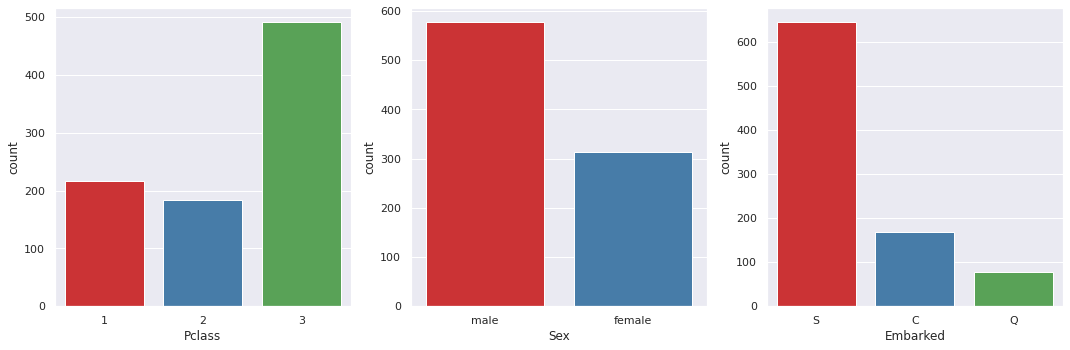

In [12]:
#Categorical columns
fig = plt.figure(figsize=(15,5))
sns.set_style('darkgrid')
for index,col in enumerate(cat_col):
    plt.subplot(1,3,index+1)
    sns.set(font_scale = 1.0)
    sns.countplot(train[col], palette='Set1')
fig.tight_layout(pad=1.0)

Data observation :
* Most passenger were from class 3 
* There were more male than female onboard
* Most of passenger embarked at Southampton port following by Cherbourg and Queenstown

## Bivariate analysis

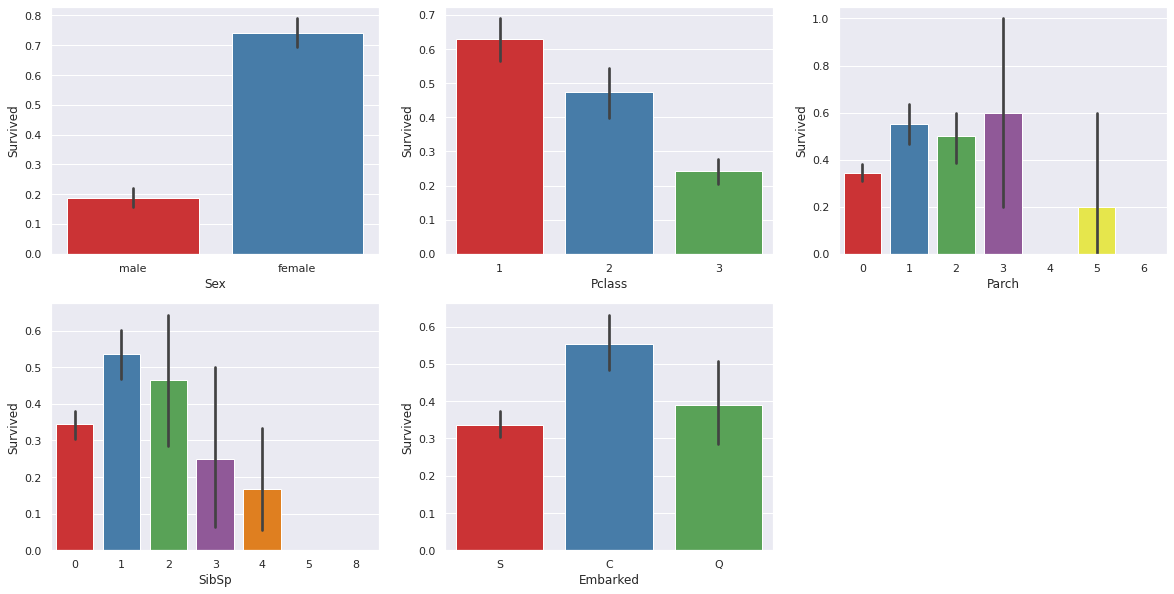

In [13]:
fig = plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
sns.barplot(x="Sex", y="Survived", data=train, palette = 'Set1')
plt.subplot(2,3,2)
sns.barplot(x="Pclass", y="Survived", data=train, palette = 'Set1')
plt.subplot(2,3,3)
sns.barplot(x="Parch", y="Survived", data=train, palette = 'Set1')
plt.subplot(2,3,4)
sns.barplot(x="SibSp", y="Survived", data=train, palette = 'Set1')
plt.subplot(2,3,5)
sns.barplot(x="Embarked", y="Survived", data=train, palette = 'Set1')

In [14]:
bins_fare = np.linspace(0,200,5)
bins_age = np.linspace(0,80,5)
train['binned_fare'] = pd.cut(train['Fare'],bins_fare)
train['binned_age'] = pd.cut(train['Age'],bins_age)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,binned_fare,binned_age
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,"(0.0, 50.0]","(20.0, 40.0]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,"(50.0, 100.0]","(20.0, 40.0]"
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,"(0.0, 50.0]","(20.0, 40.0]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,"(50.0, 100.0]","(20.0, 40.0]"
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,"(0.0, 50.0]","(20.0, 40.0]"


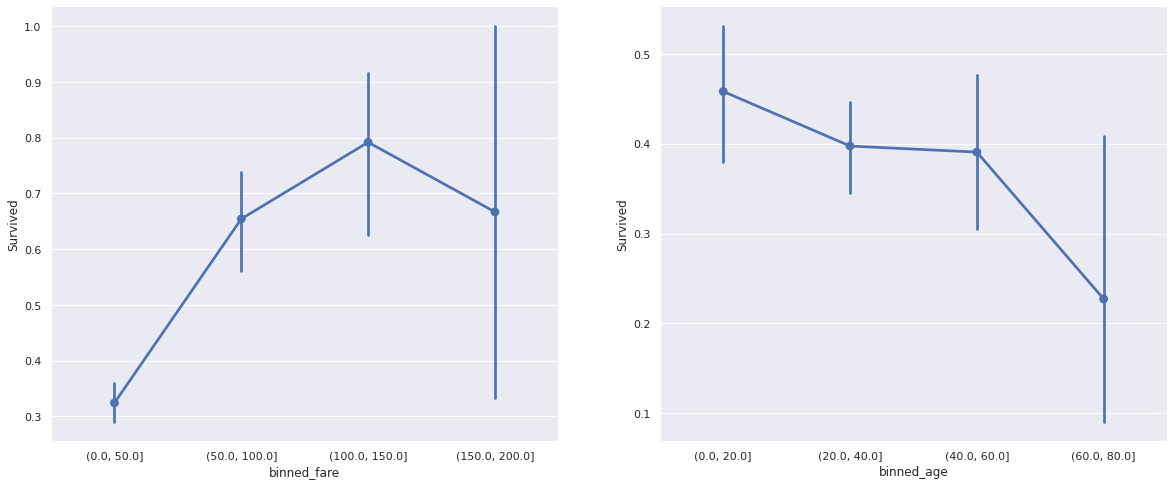

In [15]:
fig = plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
ax = sns.pointplot(x="binned_fare", y="Survived", data=train)
plt.subplot(1,2,2)
ax = sns.pointplot(x="binned_age", y="Survived", data=train)

Data Observation:
* Sex : Female has significantly higher rate of survival than male
* Pclass : 1st class passenger has highest rate of survival follow by 2nd class and 3rd class respectively
* #Parch : doesn't show strong relationship with survival rate
* #SibSp : as # of siblings / spouses increased, survival rate tend to decrease
* Embarked port : Passenger embarked from Cherbourg has highest rate of survival
* Fare : passenger with fare in range [100,150] has highest survival rate
* age : Elderly people has significant lower rate of survival than adult and younger people

# 3.Data preprocessing <a id=3>

In [16]:
df = pd.read_csv('../input/titanic/train.csv')

In [17]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [18]:
#Check amount of missing values by columns
df.isnull().mean().sort_values(ascending=False)

Cabin          0.771044
Age            0.198653
Embarked       0.002245
Fare           0.000000
Ticket         0.000000
Parch          0.000000
SibSp          0.000000
Sex            0.000000
Name           0.000000
Pclass         0.000000
Survived       0.000000
PassengerId    0.000000
dtype: float64

* Columns 'Cabin' has more than 77% missing so we'll drop out this columns from our consideration
* Columns 'Age' is missing about 20%. But they're imputable, so we dicide to keep it for further processing
* Columns 'Embarked' and 'Fare' almost perfect (missing less than 1%). We'll keep these columns for further processing

In [19]:
X_train = df.drop(columns=['Survived']).copy()
y_train = df['Survived'].copy()

In [20]:
cat_col = ['Pclass','Sex','Embarked']
num_col = ['Fare','Age','SibSp','Parch']
name_col = ['Name']

As we can see here, our features have different characteristics as follow

* Categorical features : Pclass , Sex , Embarked
* Numerical feafutres : Fare, Age, #SipSp, #Parch

Therefore, different type of attribute need to have different preprocessing steps as follow 

## 3.1 Categorical attributes preprocessing

mainly will consist of 2 steps

1. **Imputing** (filling missing value) by its most frequent. For example, "Embarked" attribute consists of 3 differrent port (C = Cherbourg, Q = Queenstown, S = Southampton) 
1. **OneHotEncoding** . Most machine learning algorithm can't intrepete text input, therefore we need to convert it into numerical in order to feed into the model 

In [21]:
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [22]:
df['Embarked'].value_counts()
print('S = ' + str((df['Embarked'].value_counts().S/df['Embarked'].value_counts().sum()*100).round(2))+"%")
print('C = ' + str((df['Embarked'].value_counts().C/df['Embarked'].value_counts().sum()*100).round(2))+"%")
print('Q = ' + str((df['Embarked'].value_counts().Q/df['Embarked'].value_counts().sum()*100).round(2))+"%")

S = 72.44%
C = 18.9%
Q = 8.66%


Almost 70% of passenger are embarked in S. Therefore, we'll fill missing values with 'S'

In [23]:
from sklearn.impute import SimpleImputer
cat_imputer = SimpleImputer(strategy = 'most_frequent')

## 3.2 Numerical attributes preprocessing

For numerical attributes, I decide to create preprocessing steps as follow,

1. **Imputing** by its median. Because some attribute contains outlier, filling with median would have less effect to attribute distribution
1. **StandardScaling** , Most machine learning algorithm work well when input features having same scale and standard deviation, so I decide to transform numerical data by standard scaling.

In [24]:
num_imputer = SimpleImputer(strategy = 'median')

## 3.3 Feature engineering (extract title from "Name" attribute)
We also found something interesting. In columns 'Name' There is title embedded inside. so we'll try to extract information about title and see if it have some relation with survival rate.

In [25]:
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand = False)
df['Title'].unique().tolist()

['Mr',
 'Mrs',
 'Miss',
 'Master',
 'Don',
 'Rev',
 'Dr',
 'Mme',
 'Ms',
 'Major',
 'Lady',
 'Sir',
 'Mlle',
 'Col',
 'Capt',
 'Countess',
 'Jonkheer']

Some of the titles above are quite unfamiliar, so we decide to replace these titles with more familiar titles which organizes our categories. After replacing these titles we only end up with 5 distinct titles.

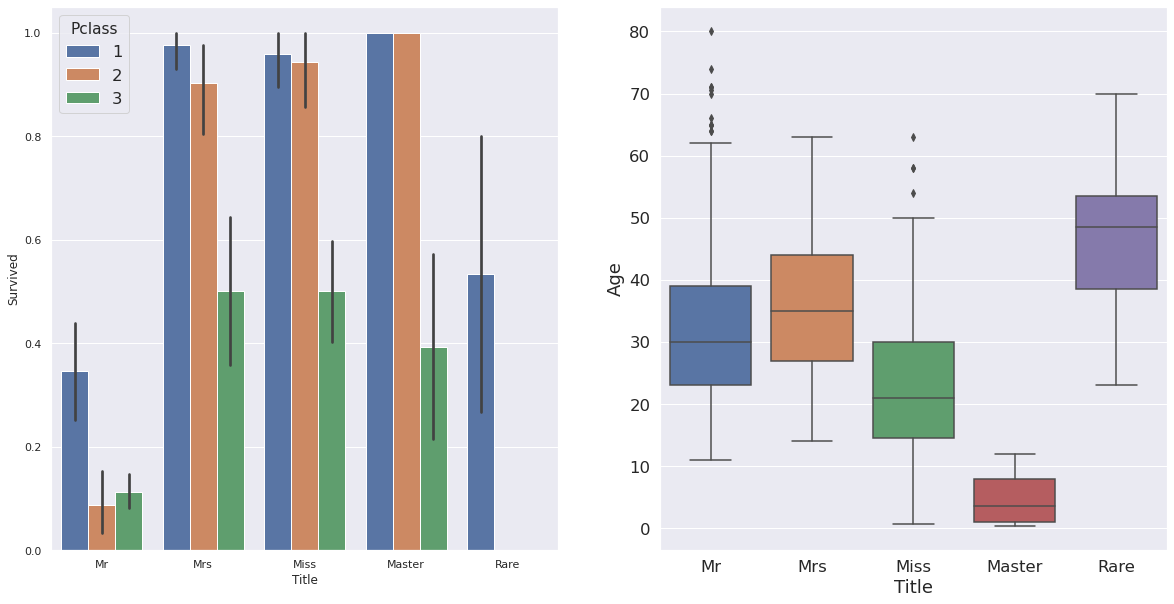

In [26]:
#Replace unfamilliar title with most familiar title

train['Title'] = train['Name'].str.extract(' ([A-Za-z]+)\.', expand = False)
train['Title'] = train['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
train['Title'] = train['Title'].replace('Mlle', 'Miss')
train['Title'] = train['Title'].replace('Ms', 'Miss')
train['Title'] = train['Title'].replace('Mme', 'Mrs')

fig = plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.set(font_scale=1.5)
sns.barplot(data=train,x='Title',y='Survived',hue='Pclass')
plt.subplot(1,2,2)
sns.set(font_scale=1.0)
sns.boxplot(data=train,x='Title',y='Age')

Title feature review some interesting insight...
1. As we discovered before, female (Mrs,Miss) have higher chance of survival than male passenger with highest chance of survival belong to 1st class passenger
1. Master title, which appeared to be children (from right boxplot) always survive for 1st and 2nd class passenger.

from my point of view, it's possible that crew and male passengers focus their effort on helping children and woman which result in higher survival chance of children and woman.

1st class passenger have highest chance of survival in all circumstance, it seem that priority had been given to 1st class and 2nd class passenger accordingly.

In [27]:
from sklearn.base import BaseEstimator, TransformerMixin

#Create custom transformer to extract title information from "Name" attribute
class TitleAttributeAdder(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self

    def transform(self,X):
        X_ = X.copy()
        X_['Title'] = X_['Name'].str.extract(' ([A-Za-z]+)\.', expand = False)
        X_['Title'] = X_['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
        X_['Title'] = X_['Title'].replace('Mlle', 'Miss')
        X_['Title'] = X_['Title'].replace('Ms', 'Miss')
        X_['Title'] = X_['Title'].replace('Mme', 'Mrs')
        X_ = X_.drop(columns='Name')
        return X_
    
#         title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

#         X_['Title'] = X_['Title'].map(title_mapping)

#         # Imputing missing values with 0
#         X_['Title'] = X_['Title'].fillna(0)
        

        

## 3.4 Combine preprocessing steps into pipeline

Data preprocessing steps is very exhaustive and consumed a lot of time. After deciding which preprocessing method needed for each data type, I decide to put preprocessing steps into pipeline to automate the workflow.

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

#Numerical pipeline
num_pipeline = Pipeline([
    ('imputer', num_imputer), #num_imputer = imputed with median of each features
    ('std_scaler', StandardScaler()) #z-score scaling
])

#Categorical pipeline
cat_pipeline = Pipeline([
    ('imputer', cat_imputer), #cat_imputer = imputed with most frequent object.
    ('encoder', OneHotEncoder(handle_unknown='ignore')) #convert categorical columns into one hot vectors
])

#Name pipeline
name_pipeline = Pipeline([
    ('title_adder', TitleAttributeAdder()), #extract title from "Name" attribute
    ('encoder', OneHotEncoder(handle_unknown='ignore')) #convert categorical columns into one hot vectors
])

#Finally put it into full pipeline to handle all preprocessing steps
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_col),
    ('cat', cat_pipeline, cat_col),
    ('name', name_pipeline, name_col)
])

### Dataset before transformation

Before transformation, dataset is the same as we have imported during Exploratory Data Analysis steps

In [29]:
X_train

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### Dataset after transformation

After transformantion, 

1. Numerical features has been imputed and Standard scaling
2. Categorical features has been imputed and onehotencoding as shown
3. Title has been extracted from "Name" attribute, and being onehotencoded too

In [30]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_train_prepared = pd.DataFrame(X_train_prepared,columns = full_pipeline.transformers_[0][2]+
                               full_pipeline.transformers_[1][1][1].get_feature_names().tolist()+
                               full_pipeline.transformers_[2][1][1].get_feature_names().tolist())
X_train_prepared.rename(columns = {'x0_1': 'Pclass_1',
                                  'x0_2' : 'Pclass_2',
                                  'x0_3' : 'Pclass_3',
                                  'x1_female': 'female',
                                  'x1_male': 'male',
                                  'x2_C': 'Embarked_C',
                                  'x2_Q': 'Embarked_Q',
                                  'x2_S': 'Embarked_S'})

,Fare,Age,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,female,male,Embarked_C,Embarked_Q,Embarked_S,x0_Master,x0_Miss,x0_Mr,x0_Mrs,x0_Rare
0,-0.502445,-0.565736,0.432793,-0.473674,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.786845,0.663861,0.432793,-0.473674,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.488854,-0.258337,-0.474545,-0.473674,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.420730,0.433312,0.432793,-0.473674,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,-0.486337,0.433312,-0.474545,-0.473674,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,-0.386671,-0.181487,-0.474545,-0.473674,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
887,-0.044381,-0.796286,-0.474545,-0.473674,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
888,-0.176263,-0.104637,0.432793,2.008933,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
889,-0.044381,-0.258337,-0.474545,-0.473674,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# 4. Model selection <a id=4>

We'll compare model performance from Scikit-learn model selection guideline as shown below

![Guideline](https://scikit-learn.org/stable/_static/ml_map.png)
see more at : https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

From above guideline, I've selected interesting algorithms as follow

1. Stochastic Gradient Descent Classifier (SGDClassifier)
1. LogisticRegression
1. Linear Support Vector Classifier (Linear SVC)
1. Support Vector Classifier with polynomial kernel
1. Support Vector Classifier with Gaussian RBF kernel
1. K-Nearest Neighbour Classifier (KNN)
1. Random Forest Classifier
1. Extreme Gradient Boosting Classifier (XGBClassifier)

In [31]:
np.random.seed(1)
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC , SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


model_list = [('SGDClassifier', SGDClassifier()),
              ('LogisticsRegression', LogisticRegression()),
         ('LinearSVC', LinearSVC()),
         ('PolyKernelSVC', SVC(kernel = 'poly')),
         ('RBFKernelSVC', SVC(kernel='rbf')),
         ('KNN_Classifier', KNeighborsClassifier()),
         ('RandomForestClassifer', RandomForestClassifier()),
         ('XGBClassifier', xgb.XGBClassifier())
        ]
model_score = []

for m in model_list:
    model = m[1]
    score = cross_val_score(model,X_train_prepared,y_train,cv=4, scoring='accuracy')
    print(f'{m[0]} score = {round(score.mean(),3)}')
    model_score.append([m[0],score.mean()])
    

SGDClassifier score = 0.781
LogisticsRegression score = 0.822


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC score = 0.816
PolyKernelSVC score = 0.828
RBFKernelSVC score = 0.832
KNN_Classifier score = 0.811
RandomForestClassifer score = 0.797
XGBClassifier score = 0.82


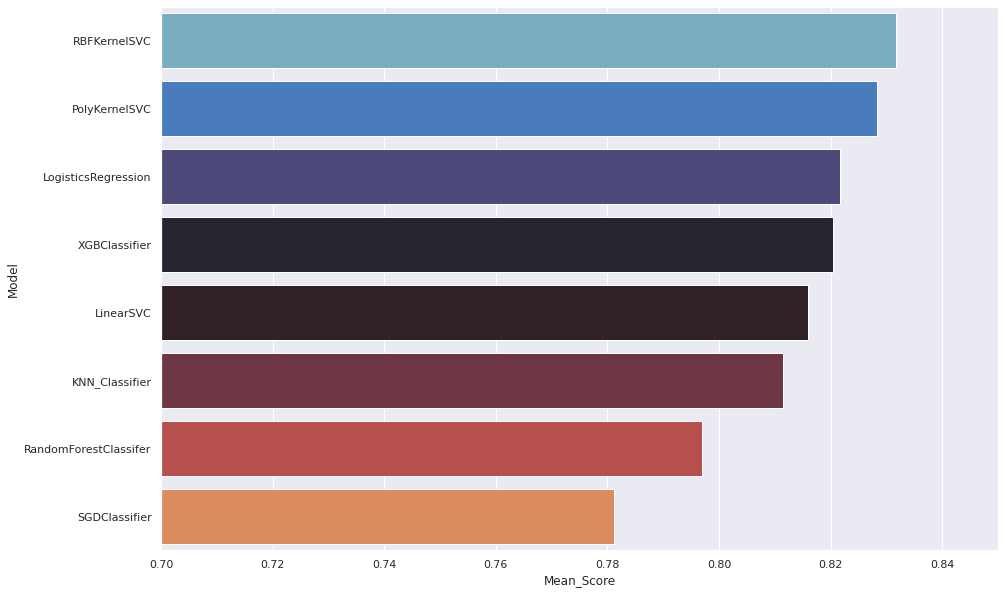

In [32]:
fig = plt.figure(figsize=(15,10))
sns.set_style('darkgrid')
sns.barplot(data = pd.DataFrame(data=model_score,columns = ['Model','Mean_Score']).sort_values(by='Mean_Score',ascending=False),
           x='Mean_Score', y = 'Model',orient='h',palette='icefire')
plt.xlim((0.7,0.85));

**By comparing default algorithm configuration ...** <br>

From average cross validation score, we'll select top 3 model to construct voting classifier. 
In order to get best performance out of voting classifier, predictors shall be trained with different algorithms.
However SVC with RBF and Poly kernel are from the same classifier (with different kernel). Therefore, we'll pick 4th classifier (XGBClassifier) instead of PolyKernelSVC to construct our voting classifier

# 5. Hyperparameter tuning <a id=5>

We'll use exhausive grid seacrh cross validiation method (GridSearchCV) to find best combination of hyperparameters for our algorithms <br>

For quick committing, I've run GridSearchCV to find optimum hyperparameters and save model for later used in order to recall saved model to train quickly.

## 5.1 Logistic Regression

In [33]:
#%%script false --no-raise-error
from sklearn.model_selection import GridSearchCV

#Hyperparameter to be tweaked for LogisticRegression
param_grid1 = [
    {'C' : [0.1,0.3,1,3,10],
    },
    {'penalty':['elasticnet'],
    'C' : [0.1,0.3,1,3,10],
    'l1_ratio' : np.linspace(0,1,6)}
]

grid_search1 = GridSearchCV(LogisticRegression(),param_grid1, cv=4, scoring = 'accuracy', return_train_score = True)
grid_search1.fit(X_train_prepared,y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)


GridSearchCV(cv=4, estimator=LogisticRegression(),
             param_grid=[{'C': [0.1, 0.3, 1, 3, 10]},
                         {'C': [0.1, 0.3, 1, 3, 10],
                          'l1_ratio': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
                          'penalty': ['elasticnet']}],
             return_train_score=True, scoring='accuracy')

In [34]:
#%%script false --no-raise-error
LogisticRegression = grid_search1.best_estimator_
joblib.dump(model , 'LogisticRegression.pkl')

['LogisticRegression.pkl']

Default setting of Logistic Regression seem to perform best so we keep using it defualt configuration for next step

## 5.2 Support Vector Classifier with RBF kernel

In [35]:
#%%script false --no-raise-error
#Hyperparameter to be tweaked
param_grid2 = [{
    'gamma' : [0.01,0.03,0.1,0.3,1],
    'C' : [0.01,0.03,0.1,0.3,1,],
}]

grid_search2 = GridSearchCV(SVC(kernel='rbf',probability=True),param_grid2, cv=4, scoring = 'accuracy', return_train_score = True, n_jobs=-1)
grid_search2.fit(X_train_prepared,y_train)

GridSearchCV(cv=4, estimator=SVC(probability=True), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.03, 0.1, 0.3, 1],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1]}],
             return_train_score=True, scoring='accuracy')

In [36]:
#%%script false --no-raise-error
SVC_rbf = grid_search2.best_estimator_
joblib.dump(model , 'SVC_rbf.pkl')

['SVC_rbf.pkl']

## 5.3 XGB Classifier

In [37]:
#%%script false --no-raise-error
#Hyperparameter to be tweaked
param_grid3 = [{
    ' n_estimators=' : [100,300,500],
    'max_depth' : [3,5,10],
    'gamma' : [0.01, 0.03, 0.1],
    'reg_lambda' : [0.1,0.3,0.5],
    'reg_alpha': [0.1,0.3,0.5]
}]

grid_search3 = GridSearchCV(xgb.XGBClassifier(),param_grid3, cv=4, scoring = 'accuracy', return_train_score = True, n_jobs=-1)
grid_search3.fit(X_train_prepared,y_train)

[10:53:15] WARNING: /workspace/src/learner.cc:480: 
Parameters: {  n_estimators= } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, va

In [38]:
#%%script false --no-raise-error
XGBC = grid_search3.best_estimator_
joblib.dump(model , 'XGBC.pkl')

['XGBC.pkl']

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 3, figsize=(20, 20))

title = "Learning Curves (LogisticRegression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

plot_learning_curve(LogisticRegression, title, X_train_prepared, y_train, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (SVM, RBF kernel)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(SVC_rbf, title, X_train_prepared, y_train, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (XGBClassifier)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(XGBC, title, X_train_prepared, y_train, axes=axes[:, 2], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)
plt.show()

Logistic Regression and SVM with RBF kernel seem a bit underfit while XGB classifier is likely to overfit the training set. <br>

In term of training speed and scalability, LogisticRegression ;with its simplicity; has fastest training speed following by XGB classifier and SVC with rbf kernel

# 6. Ensembling (Construction of Voting classifier) <a id=6>

From our top 3 best perform model, I'll try to combine them into soft voting classifier improve overall predicting performance. The reasone behind this is that, the voting classifier often achieves a higher accuracy than individual predictors used to construct its.

In [ ]:
from sklearn.ensemble import VotingClassifier

estimators = [('LogisticRegression',LogisticRegression),
              ('SVC_rbf',SVC_rbf),
              ('XGBC',XGBC)]

VClassifier = VotingClassifier(estimators,voting='soft')
VClassifier.fit(X_train_prepared,y_train)

# 7. Prediction and Submission <a id=7>

Finally, with our voting classifier, we try to predict whether passenger in test set survived the catastrophe or not

In [ ]:
#transform test set as same way we did to training set
X_test_prepared = full_pipeline.transform(test)

#put into dataframe in case we need to look at it
X_test_prepared = pd.DataFrame(X_test_prepared,columns = full_pipeline.transformers_[0][2]+
                               full_pipeline.transformers_[1][1][1].get_feature_names().tolist()+
                               full_pipeline.transformers_[2][1][1].get_feature_names().tolist())
X_test_prepared.rename(columns = {'x0_1': 'Pclass_1',
                                  'x0_2' : 'Pclass_2',
                                  'x0_3' : 'Pclass_3',
                                  'x1_female': 'female',
                                  'x1_male': 'male',
                                  'x2_C': 'Embarked_C',
                                  'x2_Q': 'Embarked_Q',
                                  'x2_S': 'Embarked_S'})

#make prediction
prediction = VClassifier.predict(X_test_prepared)

In [ ]:
result = pd.DataFrame(prediction,test.PassengerId,columns=['Survived'])
result.to_csv('Voting_classifier_prediction.csv')
result


In [ ]:
#Prediction of each individual classifier for comparison

y_log = LogisticRegression.predict(X_test_prepared)
y_svm = SVC_rbf.predict(X_test_prepared)
y_xgb = XGBC.predict(X_test_prepared)

result_log = pd.DataFrame(y_log,test.PassengerId,columns=['Survived'])
result_svm = pd.DataFrame(y_svm,test.PassengerId,columns=['Survived'])
result_xgb = pd.DataFrame(y_xgb,test.PassengerId,columns=['Survived'])

result_log.to_csv('LogisticRegression_prediction.csv')
result_svm.to_csv('SVB_rbf_prediction.csv')
result_xgb.to_csv('XGBC.csv')

#  8. Conclusion <a id=8>

Prediction of our ensemble model (Voting classifier) result in 77.99% accuracy, from the learning curves it could be that 2/3 of our model seem a bit underfit the training set, while XGB Classifier seem overfitting.

So, in the future I would try several approach to improve model performance :

1. Try to increasing more regularization parameters for XGB Classifier model
1. Try more feature engineering to add more interesting feature to the model (i.e. combine #Parch and #Sibsp into family size, try to extract information from cabin feature)
1. Try adding polynomail features
1. Train a neural network to tackle the problem.

[back to top](#0)